# **Complete Machine Learning Pipeline for IRIS Dataset**
---
# Following 10-Step Process: 
1. **Problem Understanding**
2. **Data Understanding** 
3. **Feature Understanding**
4. **Feature Engineering**
5. **Dataset Partition**
6. **Data Modelling**
7. **Evaluation** 
8. **Hyper-parameter Tuning**
9. **Best Model Building** 
10. **Conclusion**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, mean_squared_error,
                             mean_absolute_error, r2_score)
import warnings
warnings.filterwarnings('ignore')

# STEP 1: PROBLEM UNDERSTANDING
## Dataset: IRIS
Iris Dataset là một tập dữ liệu khác phù hợp với những ai mới bắt đầu với ML và muốn rèn luyện về hồi quy tuyến tính.
- Features: Sepal Length, Sepal Width, Petal Length, Petal Width (4 features)
- Target: Species (Setosa, Versicolor, Virrginica)
- Problem Type: Multi-class Classification

In [2]:
# STEP 2: DATA UNDERSTANDING
# Load dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['Target'] = iris.target
df['Target_Name'] = df['Target'].map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

In [3]:
# Data Shape
df.shape

(150, 6)

In [4]:
# First 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target,Target_Name
0,5.1,3.5,1.4,0.2,0,Setosa
1,4.9,3.0,1.4,0.2,0,Setosa
2,4.7,3.2,1.3,0.2,0,Setosa
3,4.6,3.1,1.5,0.2,0,Setosa
4,5.0,3.6,1.4,0.2,0,Setosa


In [5]:
# Basic Statistics
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [6]:
# Missing Values
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
Target               0
Target_Name          0
dtype: int64

In [7]:
outlier_indices = set()

# Check for outliers using IQR
for col in iris.feature_names:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3-Q1
  outliers = df[(df[col]<Q1-1.5*IQR) | (df[col]>Q3+1.5*IQR)]
  print(f"{col}: {len(outliers)} outliers")

  # Lưu chỉ số các dòng bị outlier
  outlier_indices.update(outliers.index)

# Loại bỏ các dòng outliers
df_clean = df.drop(list(outlier_indices))

sepal length (cm): 0 outliers
sepal width (cm): 4 outliers
petal length (cm): 0 outliers
petal width (cm): 0 outliers


In [8]:
df_clean.shape
df = df_clean

In [9]:
# Check class distribution
df['Target_Name'].value_counts()

Target_Name
Virginica     50
Versicolor    49
Setosa        47
Name: count, dtype: int64

In [10]:
df.iloc[:, :-2].skew()

sepal length (cm)    0.278417
sepal width (cm)     0.131562
petal length (cm)   -0.324099
petal width (cm)    -0.146606
dtype: float64

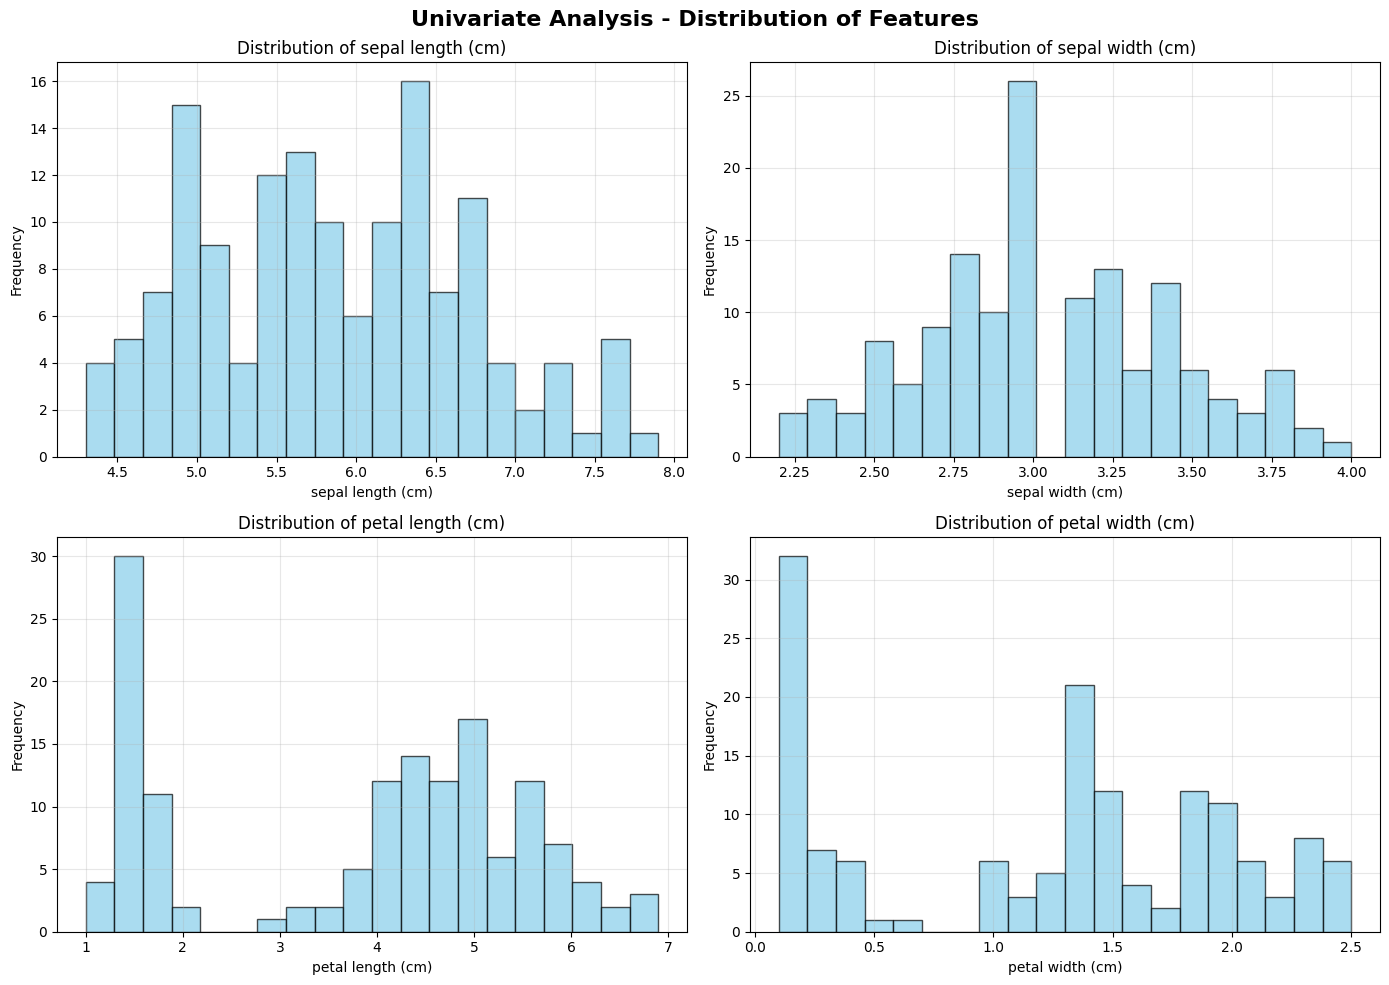

In [11]:
# STEP 3: FEATURE UNDERSTANDING - EDA WITH VISUALIZATION

fig, axes = plt.subplots(2,2, figsize=(14,10))
fig.suptitle("Univariate Analysis - Distribution of Features", fontsize=16, fontweight='bold')

for idx, col in enumerate(iris.feature_names):
    ax = axes[idx//2, idx%2]
    ax.hist(df[col], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

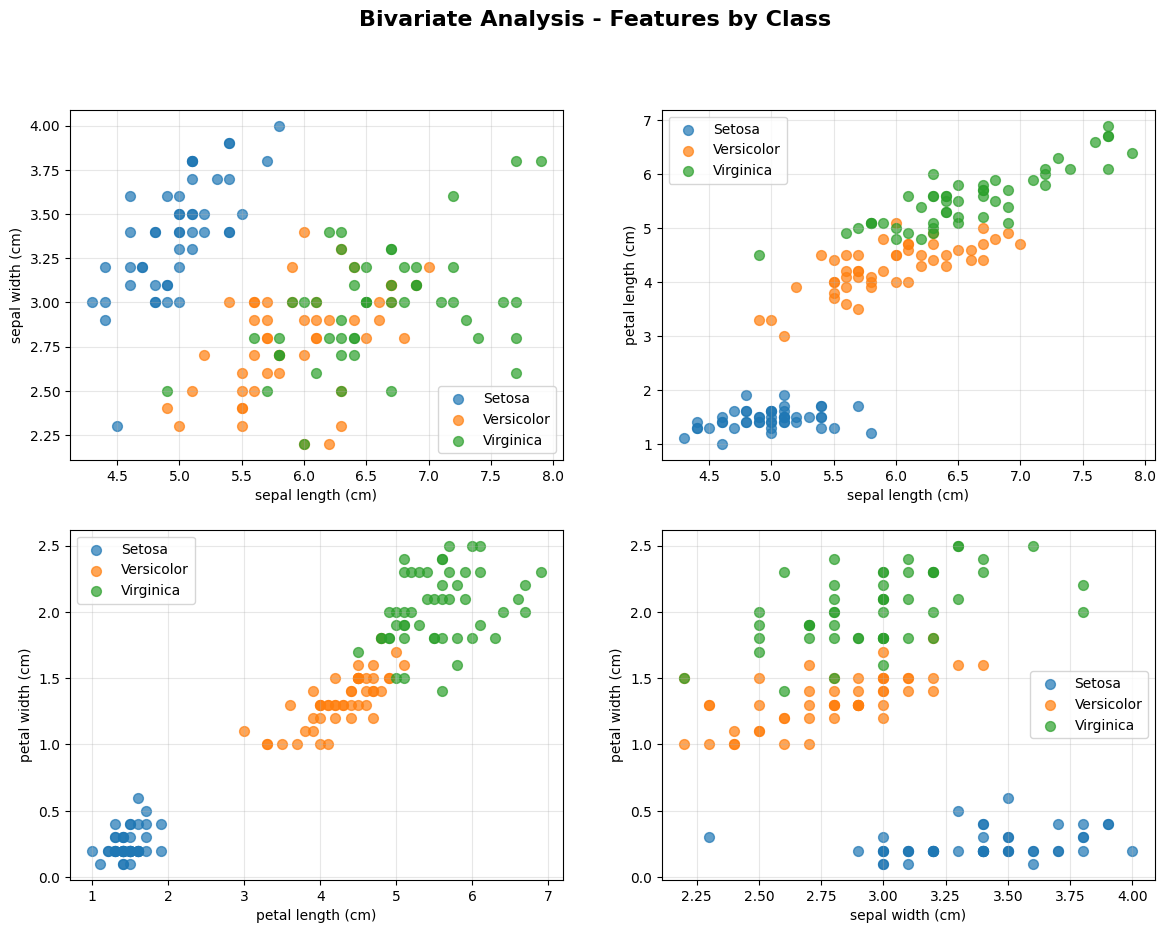

In [13]:
# Bivariate Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Bivariate Analysis - Features by Class', fontsize=16, fontweight='bold')

feature_pairs = [
    ('sepal length (cm)', 'sepal width (cm)'),
    ('sepal length (cm)', 'petal length (cm)'),
    ('petal length (cm)', 'petal width (cm)'),
    ('sepal width (cm)', 'petal width (cm)')
]

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx//2, idx%2]
    for target in [0, 1, 2]:
        mask = df['Target'] == target
        ax.scatter(df[mask][feat1], df[mask][feat2],
                  label=df[df['Target']==target]['Target_Name'].iloc[0], s=50, alpha=0.7)
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.legend()
    ax.grid(alpha=0.3)

plt.show()

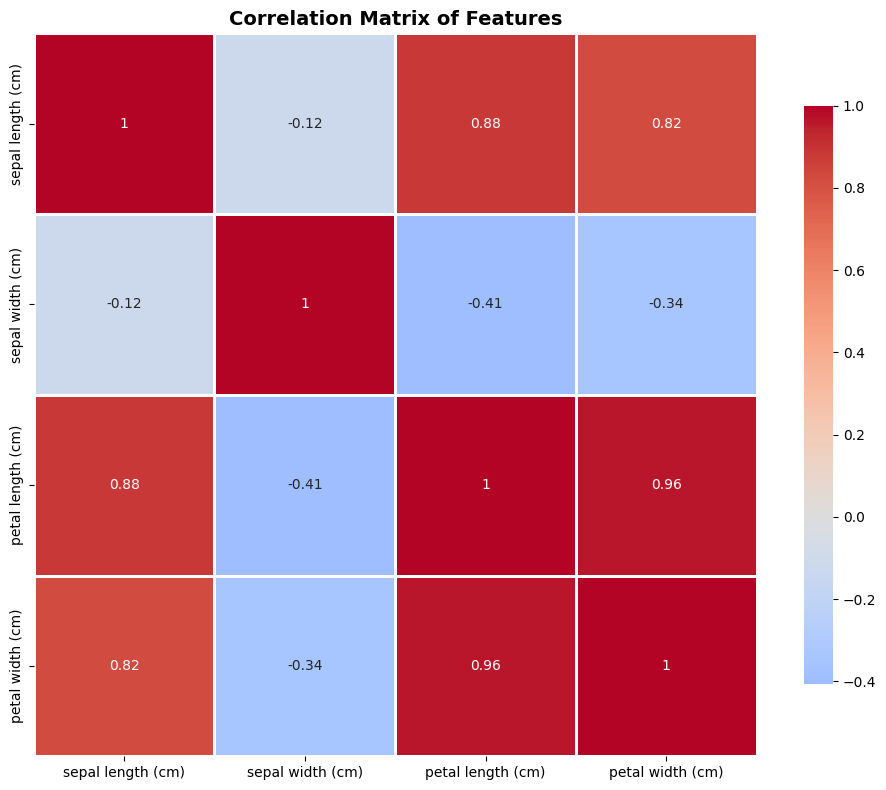

In [14]:

# Multivariate Analysis - Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
correlation = df.iloc[:, :-2].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix of Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# STEP 4: FEATURE ENGINEERING

X = df.iloc[:, :-2].values
y = df['Target'].values

print(X.shape)
print(y.shape)

(146, 4)
(146,)


1. Check for missing values (already done, but confirming)
2. Outlier handling using IQR
3. Feature Encoding (already numeric)
4. Feature Enrichment
5. Feature Transformation
6. Feature Selection

In [16]:
# STEP 5: DATASET PARTITION
# Train-Test Split (80-20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y
)

In [17]:
X_train.shape

(116, 4)

In [18]:
y_train.shape

(116,)

In [19]:
# Class distribution in Training set:
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_train)*100:.1f}%)")

print('=============')

# Class distribution in Test set:
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_test)*100:.1f}%)")

  Class 0: 37 (31.9%)
  Class 1: 39 (33.6%)
  Class 2: 40 (34.5%)
  Class 0: 10 (33.3%)
  Class 1: 10 (33.3%)
  Class 2: 10 (33.3%)
